In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samayashar/fraud-detection-transactions-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\xrzha\.cache\kagglehub\datasets\samayashar\fraud-detection-transactions-dataset\versions\1


In [7]:
import pandas as pd

# =====================
# Load original data
# =====================

try:
    df_original = pd.read_csv("C:/Users/xrzha/.cache/kagglehub/datasets/samayashar/fraud-detection-transactions-dataset/versions/1/synthetic_fraud_dataset.csv")
    print("Original data loaded successfully. Shape:", df_original.shape)
    print("Original class distribution:\n", df_original['Fraud_Label'].value_counts())

except FileNotFoundError:
    print("Error: Original data file not found. Please check the path.")
    exit()

# Define original feature columns and target
# Exclude Transaction_ID as it's likely just an identifier
original_features = [col for col in df_original.columns if col not in ['Transaction_ID', 'Fraud_Label']]
target = 'Fraud_Label'

X_original = df_original[original_features]
y_original = df_original[target]

Original data loaded successfully. Shape: (50000, 21)
Original class distribution:
 Fraud_Label
0    33933
1    16067
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

# =====================
# Train/Test Split on Original Data
# =====================

print("\nPerforming Train/Test split on original data...")
# Split data into training and testing sets BEFORE any sampling
# Stratify by y to ensure both train and test sets have similar class distribution as original
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("Training set class distribution:\n", y_train.value_counts())
print("Testing set class distribution:\n", y_test.value_counts())


Performing Train/Test split on original data...
Training set shape: (40000, 19)
Testing set shape: (10000, 19)
Training set class distribution:
 Fraud_Label
0    27168
1    12832
Name: count, dtype: int64
Testing set class distribution:
 Fraud_Label
0    6765
1    3235
Name: count, dtype: int64


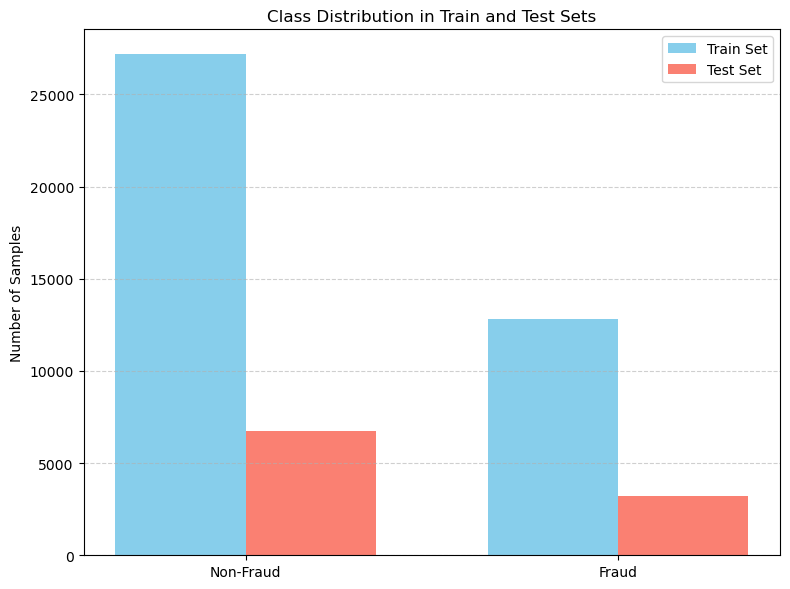

In [13]:
import matplotlib.pyplot as plt

# Data
train_counts = {'Non-Fraud': 27168, 'Fraud': 12832}
test_counts = {'Non-Fraud': 6765, 'Fraud': 3235}

labels = list(train_counts.keys())
x = range(len(labels))

train_values = list(train_counts.values())
test_values = list(test_counts.values())

# Plot
plt.figure(figsize=(8, 6))
bar_width = 0.35
plt.bar([p - bar_width/2 for p in x], train_values, width=bar_width, label='Train Set', color='skyblue')
plt.bar([p + bar_width/2 for p in x], test_values, width=bar_width, label='Test Set', color='salmon')

# Labels
plt.xticks(x, labels)
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Train and Test Sets')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Performing EDA on original training data...
Calculating fraud rate by Transaction Type on original training data...


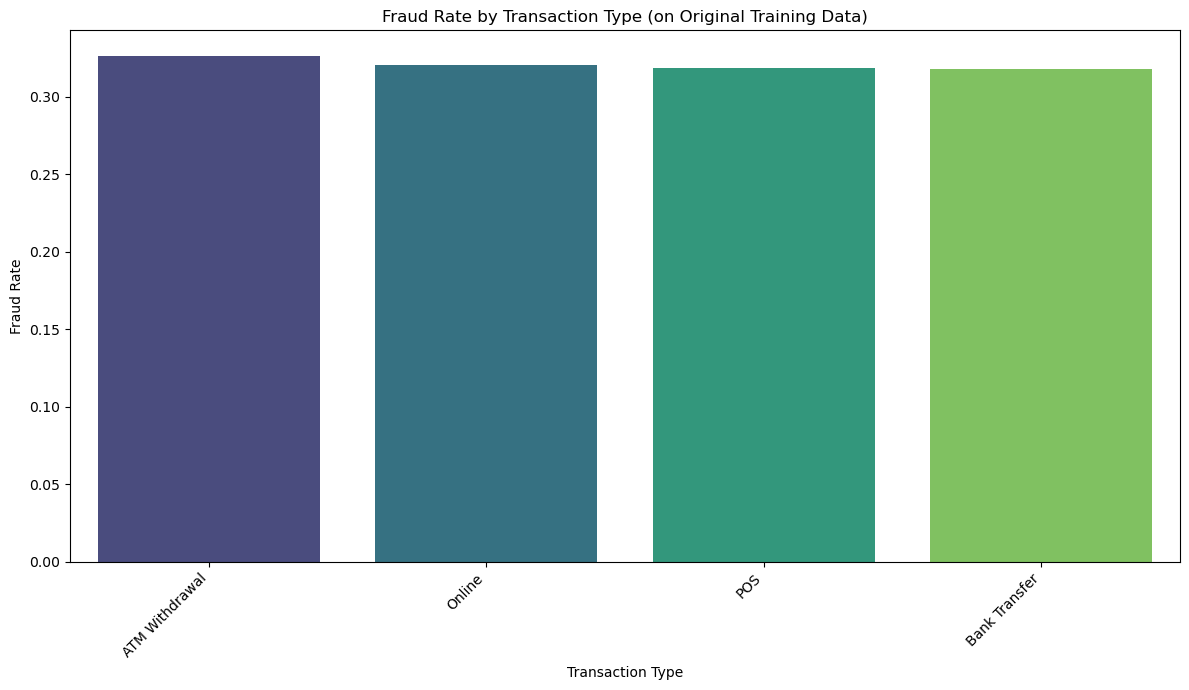

In [19]:
import seaborn as sns # Import for plotting

# ========================
# EDA on Original Training Data
# ========================
print("\nPerforming EDA on original training data...")

# Combine X_train and y_train for easier plotting
train_data_eda = X_train.copy()
train_data_eda['Fraud_Label'] = y_train

# Visualize Fraud Rate by Transaction Type
print("Calculating fraud rate by Transaction Type on original training data...")

# Calculate the fraud rate (mean of Fraud_Label) for each Transaction_Type
fraud_rate_by_type_train = train_data_eda.groupby('Transaction_Type')['Fraud_Label'].mean().reset_index()

# Sort by fraud rate for better visualization
fraud_rate_by_type_train = fraud_rate_by_type_train.sort_values(by='Fraud_Label', ascending=False)

plt.figure(figsize=(12, 7))
# Use hue for coloring by Transaction_Type, consistent with previous fix
sns.barplot(x='Transaction_Type', y='Fraud_Label', data=fraud_rate_by_type_train, palette='viridis', hue='Transaction_Type', legend=False)
plt.title('Fraud Rate by Transaction Type (on Original Training Data)')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Calculating and visualizing correlation matrix for original numeric features on training data...


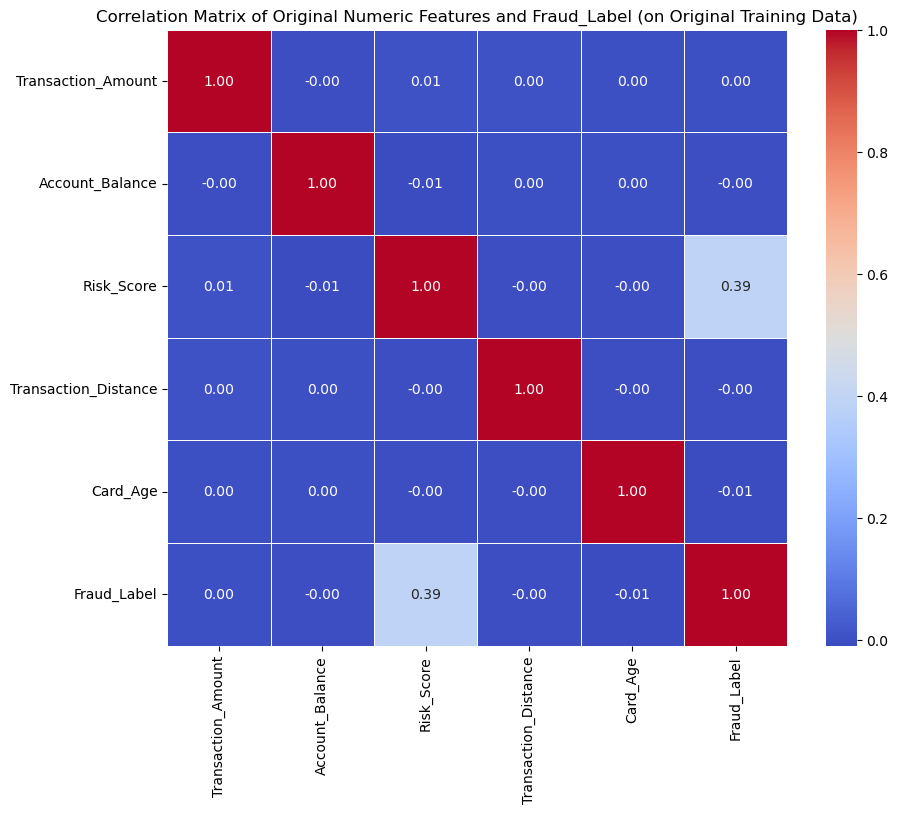

In [21]:
# Visualize Correlation Matrix for Original Numeric Features
print("\nCalculating and visualizing correlation matrix for original numeric features on training data...")

# Identify original numeric features from X_train
# Ensure this list matches the numeric features BEFORE any feature engineering
original_numeric_features = ['Transaction_Amount', 'Account_Balance', 'Risk_Score',
                             'Transaction_Distance', 'Card_Age'] # Adjust based on your original data

# Add the target variable 'Fraud_Label' for correlation
features_for_correlation_train = original_numeric_features + ['Fraud_Label']

# Calculate the correlation matrix using the combined training data for EDA
# Only select the columns relevant for this original correlation matrix
correlation_matrix_train = train_data_eda[features_for_correlation_train].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Original Numeric Features and Fraud_Label (on Original Training Data)')
plt.show()

In [23]:
# =====================
# 4. Feature Engineering (Apply separately to Train and Test)
# =====================

print("\nStarting Feature Engineering on Train and Test sets...")

# Define the function for feature engineering steps (same as before)
def apply_feature_engineering(df):
    df_engineered = df.copy()

    # Temporal Features
    if 'Timestamp' in df_engineered.columns:
        if not pd.api.types.is_datetime64_any_dtype(df_engineered['Timestamp']):
            try:
                df_engineered['Timestamp'] = pd.to_datetime(df_engineered['Timestamp'])
            except ValueError as e:
                print(f"Error converting Timestamp: {e}. Skipping temporal features.")
                df_engineered['Transaction_Hour'] = np.nan
                df_engineered['Transaction_Weekday'] = np.nan
                df_engineered['Transaction_Day'] = np.nan
                df_engineered['Transaction_Month'] = np.nan
                df_engineered['Is_Weekend'] = np.nan
                timestamp_ok = False
            else:
                df_engineered['Transaction_Hour'] = df_engineered['Timestamp'].dt.hour
                df_engineered['Transaction_Weekday'] = df_engineered['Timestamp'].dt.dayofweek
                df_engineered['Transaction_Day'] = df_engineered['Timestamp'].dt.day
                df_engineered['Transaction_Month'] = df_engineered['Timestamp'].dt.month
                df_engineered['Is_Weekend'] = (df_engineered['Transaction_Weekday'] >= 5).astype(int)
                timestamp_ok = True
        else:
            df_engineered['Transaction_Hour'] = df_engineered['Timestamp'].dt.hour
            df_engineered['Transaction_Weekday'] = df_engineered['Timestamp'].dt.dayofweek
            df_engineered['Transaction_Day'] = df_engineered['Timestamp'].dt.day
            df_engineered['Transaction_Month'] = df_engineered['Timestamp'].dt.month
            df_engineered['Is_Weekend'] = (df_engineered['Transaction_Weekday'] >= 5).astype(int)
            timestamp_ok = True
    else:
        print("Warning: 'Timestamp' column not found. Skipping temporal feature engineering.")
        df_engineered['Transaction_Hour'] = np.nan
        df_engineered['Transaction_Weekday'] = np.nan
        df_engineered['Transaction_Day'] = np.nan
        df_engineered['Transaction_Month'] = np.nan
        df_engineered['Is_Weekend'] = np.nan
        timestamp_ok = False


    # Behavioral Features (Using User_ID and Timestamp)
    if 'User_ID' in df_engineered.columns and 'Timestamp' in df_engineered.columns and 'Transaction_Amount' in df_engineered.columns and timestamp_ok:
        df_engineered = df_engineered.sort_values(by=['User_ID', 'Timestamp'])
        df_engineered['Time_Diff_Prev_Transaction'] = df_engineered.groupby('User_ID')['Timestamp'].diff().dt.total_seconds().fillna(0)
        df_engineered['User_Avg_Transaction_Amount_Cumulative'] = df_engineered.groupby('User_ID')['Transaction_Amount'].expanding().mean().reset_index(level=0, drop=True)
        df_engineered['User_Max_Transaction_Amount_Cumulative'] = df_engineered.groupby('User_ID')['Transaction_Amount'].expanding().max().reset_index(level=0, drop=True)
        df_engineered['Amount_Deviation_From_User_Avg'] = df_engineered['Transaction_Amount'] - df_engineered['User_Avg_Transaction_Amount_Cumulative']
        print("Behavioral features applied.")
    else:
        print("Warning: Required columns or Timestamp not correctly processed for behavioral feature engineering. Skipping.")
        df_engineered['Time_Diff_Prev_Transaction'] = np.nan
        df_engineered['User_Avg_Transaction_Amount_Cumulative'] = np.nan
        df_engineered['User_Max_Transaction_Amount_Cumulative'] = np.nan
        df_engineered['Amount_Deviation_From_User_Avg'] = np.nan


    # Composite Risk Indicator
    if 'Risk_Score' in df_engineered.columns and 'Previous_Fraudulent_Activity' in df_engineered.columns:
        df_engineered['Composite_Risk'] = df_engineered['Risk_Score'] + df_engineered['Previous_Fraudulent_Activity']
        print("Composite risk indicator applied.")
    elif 'Risk_Score' in df_engineered.columns and any('Previous_F' in col for col in df_engineered.columns):
         print("Warning: 'Previous_Fraudulent_Activity' column not found. Found a potentially related column. Please verify and correct the column name in apply_feature_engineering function if needed.")
         df_engineered['Composite_Risk'] = np.nan
    else:
         print("Warning: 'Risk_Score' or 'Previous_Fraudulent_Activity' (or similar) columns not found. Skipping composite risk feature engineering.")
         df_engineered['Composite_Risk'] = np.nan


    return df_engineered

# Apply feature engineering to training and testing sets
X_train_engineered = apply_feature_engineering(X_train)
X_test_engineered = apply_feature_engineering(X_test)

print(f"\nTraining set shape after engineering: {X_train_engineered.shape}")
print(f"Testing set shape after engineering: {X_test_engineered.shape}")



Starting Feature Engineering on Train and Test sets...
Behavioral features applied.
Composite risk indicator applied.
Behavioral features applied.
Composite risk indicator applied.

Training set shape after engineering: (40000, 28)
Testing set shape after engineering: (10000, 28)


In [27]:
# =====================
# Handle Class Imbalance (Apply to Training Set)
# =====================

from imblearn.under_sampling import RandomUnderSampler

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply sampling to the engineered training features and original training labels
X_train_sampled, y_train_sampled = rus.fit_resample(X_train_engineered, y_train.reset_index(drop=True))

print(f"Training set shape AFTER sampling: {X_train_sampled.shape}")
print("Training set class distribution AFTER sampling:\n", pd.Series(y_train_sampled).value_counts())

Training set shape AFTER sampling: (25664, 28)
Training set class distribution AFTER sampling:
 Fraud_Label
0    12832
1    12832
Name: count, dtype: int64


In [41]:
# =====================
# Data Preprocessing Pipeline (Fit on Sampled Train, Transform Train and Test)
# =====================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define numeric and categorical feature columns from the ENGINEERED data
# Ensure IDs and Timestamps are excluded from processing AND DROPPED
all_engineered_cols = X_train_engineered.columns.tolist()
# Columns to exclude from processing and drop from the final processed data
cols_to_exclude_from_processing = ['User_ID', 'Timestamp', 'Transaction_ID'] # Added 'Transaction_ID' just in case

numeric_features_final = [col for col in all_engineered_cols if X_train_engineered[col].dtype in ['int64', 'float64'] and col not in cols_to_exclude_from_processing]
categorical_features_final = [col for col in all_engineered_cols if X_train_engineered[col].dtype == 'object' and col not in cols_to_exclude_from_processing]

# Check if any columns are missed (optional but recommended)
# missing_cols = [col for col in all_engineered_cols if col not in numeric_features_final + categorical_features_final + cols_to_exclude_from_processing]
# if missing_cols:
#     print(f"Warning: The following engineered columns are not included in processing lists or exclude list: {missing_cols}")
#     # Consider if these missing columns should be in numeric/categorical lists or exclude list


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor - set remainder='drop'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_final),
        ('cat', categorical_transformer, categorical_features_final)
    ],
    remainder='drop' # <-- Changed from 'passthrough' to 'drop'
)

# Fit the preprocessor ONLY on the SAMPLED training data
print("Fitting preprocessor on sampled training data...")
# Ensure X_train_sampled is in a format accepted by ColumnTransformer (e.g., DataFrame)
# If the sampler converted it to numpy, you might need to convert it back or adjust preprocessor definition
preprocessor.fit(X_train_sampled)

# Transform the SAMPLED training data and the ENGINEERED test data
print("Transforming sampled training data and engineered test data...")
X_train_processed = preprocessor.transform(X_train_sampled)
X_test_processed = preprocessor.transform(X_test_engineered)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

Fitting preprocessor on sampled training data...
Transforming sampled training data and engineered test data...
Processed training data shape: (25664, 40)
Processed testing data shape: (10000, 40)


In [43]:
# =====================
# Implement and Train Logistic Regression Model
# =====================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

# Initialize the Logistic Regression model
model_lr = LogisticRegression(solver='liblinear', random_state=42)

# Train the model on the PROCESSED AND SAMPLED training data
# X_train_processed should now only contain numerical and one-hot encoded features
model_lr.fit(X_train_processed, y_train_sampled)

print("Logistic Regression model training complete.")

# =====================
# 8. Evaluate the Model (on the ORIGINAL, UNBALANCED Test Set)
# =====================
print("\nEvaluating Logistic Regression model on the ORIGINAL, UNBALANCED Test Set...")

# Predict on the PROCESSED TEST data
y_pred_lr = model_lr.predict(X_test_processed)
y_proba_lr = model_lr.predict_proba(X_test_processed)[:, 1]

print("Classification Report (on original UNBALANCED test data):")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix (on original UNBALANCED test data):")
print(confusion_matrix(y_test, y_pred_lr))

print(f"AUC-ROC (on original UNBALANCED test data): {roc_auc_score(y_test, y_proba_lr):.4f}")
print(f"AUC-PR (on original UNBALANCED test data): {average_precision_score(y_test, y_proba_lr):.4f}")

Logistic Regression model training complete.

Evaluating Logistic Regression model on the ORIGINAL, UNBALANCED Test Set...
Classification Report (on original UNBALANCED test data):
              precision    recall  f1-score   support

           0       0.68      0.48      0.56      6765
           1       0.32      0.52      0.40      3235

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.56      0.50      0.51     10000

Confusion Matrix (on original UNBALANCED test data):
[[3275 3490]
 [1556 1679]]
AUC-ROC (on original UNBALANCED test data): 0.4984
AUC-PR (on original UNBALANCED test data): 0.3255


In [45]:
# =====================
# Implement and Train Random Forest Model
# =====================
print("\nImplementing and training Random Forest model...")

from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
# n_estimators: number of trees in the forest
# random_state: for reproducibility
# class_weight='balanced_subsample' can be useful even with sampling,
# it weights samples within each tree's bootstrap sample.
# However, since we already undersampled, let's start without explicit class_weight
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

# Train the model on the PROCESSED AND SAMPLED training data
model_rf.fit(X_train_processed, y_train_sampled)

print("Random Forest model training complete.")

# =====================
# Evaluate the Random Forest Model (on the ORIGINAL, UNBALANCED Test Set)
# =====================
print("\nEvaluating Random Forest model on the ORIGINAL, UNBALANCED Test Set...")

# Predict on the PROCESSED TEST data
y_pred_rf = model_rf.predict(X_test_processed)
y_proba_rf = model_rf.predict_proba(X_test_processed)[:, 1] # Get probabilities for the positive class

print("Classification Report (Random Forest on original UNBALANCED test data):")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix (Random Forest on original UNBALANCED test data):")
print(confusion_matrix(y_test, y_pred_rf))

print(f"AUC-ROC (Random Forest on original UNBALANCED test data): {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"AUC-PR (Random Forest on original UNBALANCED test data): {average_precision_score(y_test, y_proba_rf):.4f}")


Implementing and training Random Forest model...
Random Forest model training complete.

Evaluating Random Forest model on the ORIGINAL, UNBALANCED Test Set...
Classification Report (Random Forest on original UNBALANCED test data):
              precision    recall  f1-score   support

           0       0.67      0.55      0.60      6765
           1       0.32      0.44      0.37      3235

    accuracy                           0.51     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.56      0.51      0.53     10000

Confusion Matrix (Random Forest on original UNBALANCED test data):
[[3705 3060]
 [1819 1416]]
AUC-ROC (Random Forest on original UNBALANCED test data): 0.4859
AUC-PR (Random Forest on original UNBALANCED test data): 0.3149


In [47]:
# =====================
# Implement and Train SVM Model
# =====================
print("\nImplementing and training SVM model...")

from sklearn.svm import SVC

# Initialize the SVM model
# kernel='rbf' for non-linear boundary
# probability=True to enable predict_proba (needed for AUC-ROC/AUC-PR) - can slow down training
# Note: SVM can be sensitive to scaling, which is handled by the preprocessor.
# class_weight='balanced' can be useful here if not sampling, but with sampling, it might not be needed.
# Let's start without explicit class_weight, relying on sampled data.
# Due to potential training time, you might start with a smaller subset or simpler kernel if needed.
model_svm = SVC(kernel='rbf', probability=True, random_state=42) # Set probability=True

# Train the model on the PROCESSED AND SAMPLED training data
# SVM training can take significant time on large datasets
try:
    model_svm.fit(X_train_processed, y_train_sampled)
    print("SVM model training complete.")

    # =====================
    # Evaluate the SVM Model (on the ORIGINAL, UNBALANCED Test Set)
    # =====================
    print("\nEvaluating SVM model on the ORIGINAL, UNBALANCED Test Set...")

    # Predict on the PROCESSED TEST data
    y_pred_svm = model_svm.predict(X_test_processed)
    y_proba_svm = model_svm.predict_proba(X_test_processed)[:, 1] # Get probabilities for the positive class

    print("Classification Report (SVM on original UNBALANCED test data):")
    print(classification_report(y_test, y_pred_svm))

    print("Confusion Matrix (SVM on original UNBALANCED test data):")
    print(confusion_matrix(y_test, y_pred_svm))

    print(f"AUC-ROC (SVM on original UNBALANCED test data): {roc_auc_score(y_test, y_proba_svm):.4f}")
    print(f"AUC-PR (SVM on original UNBALANCED test data): {average_precision_score(y_test, y_proba_svm):.4f}")

except Exception as e:
    print(f"An error occurred during SVM training or evaluation: {e}")
    print("SVM training might be computationally intensive. Consider reducing the dataset size or using a linear kernel for initial testing.")


Implementing and training SVM model...
SVM model training complete.

Evaluating SVM model on the ORIGINAL, UNBALANCED Test Set...
Classification Report (SVM on original UNBALANCED test data):
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      6765
           1       0.32      0.48      0.38      3235

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.56      0.50      0.52     10000

Confusion Matrix (SVM on original UNBALANCED test data):
[[3473 3292]
 [1683 1552]]
AUC-ROC (SVM on original UNBALANCED test data): 0.5053
AUC-PR (SVM on original UNBALANCED test data): 0.3237


In [51]:
# =====================
# Implement and Train Neural Network Model (MLPClassifier) - Corrected max_iter
# =====================
print("\nImplementing and training Neural Network model (MLPClassifier) with increased max_iter...")

from sklearn.neural_network import MLPClassifier

# Initialize the MLPClassifier model
# Increased max_iter to allow more training epochs
model_nn = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42, activation='relu', solver='adam') # Increased max_iter to 500

# Train the model on the PROCESSED AND SAMPLED training data
try:
    model_nn.fit(X_train_processed, y_train_sampled)
    print("Neural Network model training complete.")

    # =====================
    # Evaluate the Neural Network Model (on the ORIGINAL, UNBALANCED Test Set)
    # =====================
    print("\nEvaluating Neural Network model on the ORIGINAL, UNBALANCED Test Set...")

    # Predict on the PROCESSED TEST data
    y_pred_nn = model_nn.predict(X_test_processed)
    y_proba_nn = model_nn.predict_proba(X_test_processed)[:, 1] # Get probabilities for the positive class

    print("Classification Report (Neural Network on original UNBALANCED test data):")
    print(classification_report(y_test, y_pred_nn))

    print("Confusion Matrix (Neural Network on original UNBALANCED test data):")
    print(confusion_matrix(y_test, y_pred_nn))

    print(f"AUC-ROC (Neural Network on original UNBALANCED test data): {roc_auc_score(y_test, y_proba_nn):.4f}")
    print(f"AUC-PR (Neural Network on original UNBALANCED test data): {average_precision_score(y_test, y_proba_nn):.4f}")

except Exception as e:
    print(f"An error occurred during Neural Network training or evaluation: {e}")
    print("MLPClassifier training might require tuning parameters like max_iter or network structure.")


Implementing and training Neural Network model (MLPClassifier) with increased max_iter...
Neural Network model training complete.

Evaluating Neural Network model on the ORIGINAL, UNBALANCED Test Set...
Classification Report (Neural Network on original UNBALANCED test data):
              precision    recall  f1-score   support

           0       0.67      0.53      0.59      6765
           1       0.32      0.45      0.37      3235

    accuracy                           0.51     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.56      0.51      0.52     10000

Confusion Matrix (Neural Network on original UNBALANCED test data):
[[3607 3158]
 [1770 1465]]
AUC-ROC (Neural Network on original UNBALANCED test data): 0.4940
AUC-PR (Neural Network on original UNBALANCED test data): 0.3185
